In [8]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARMA,ARIMA
from statsmodels.tsa.stattools import adfuller

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
def parser(s):
    return datetime.strptime(s,'%Y-%m-%d')

def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:%f, p-value:%f'%(result[0],result[1]))

In [11]:
import pandas_datareader.data as web

In [12]:
start_day = datetime(2012,6,13)
end_day = datetime(2022,6,13)
dj1 = web.get_data_stooq('^DJI',start_day,end_day)

In [16]:
dj1.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2022-06-13,31144.91,31144.91,30373.72,30516.74,526922052
2022-06-10,32053.52,32053.52,31387.84,31392.79,411949075
2022-06-09,32828.62,32956.73,32267.78,32272.79,331546530
2022-06-08,33087.07,33156.50,32824.37,32910.90,314420559
2022-06-07,32783.03,33207.45,32641.85,33180.14,327463783


In [38]:
dj1.index = pd.DatetimeIndex(dj1.index.values,freq = dj1.index.inferred_freq)

In [142]:
for col in list(dj1.columns):
    print(" ADF test of %s,diff_1_%s, diff_2%s "%(col,col,col))
    perform_adf_test(dj1[col])
    perform_adf_test(dj1[col].diff(1).dropna())
    perform_adf_test(dj1[col].diff(2).dropna())

 ADF test of Open,diff_1_Open, diff_2Open 
ADF Statistic:-1.008920, p-value:0.749997
ADF Statistic:-33.742963, p-value:0.000000
ADF Statistic:-10.346079, p-value:0.000000
 ADF test of High,diff_1_High, diff_2High 
ADF Statistic:-0.731254, p-value:0.838487
ADF Statistic:-11.540263, p-value:0.000000
ADF Statistic:-10.779945, p-value:0.000000
 ADF test of Low,diff_1_Low, diff_2Low 
ADF Statistic:-1.080781, p-value:0.722675
ADF Statistic:-16.272660, p-value:0.000000
ADF Statistic:-10.468212, p-value:0.000000
 ADF test of Close,diff_1_Close, diff_2Close 
ADF Statistic:-1.015071, p-value:0.747728
ADF Statistic:-16.028321, p-value:0.000000
ADF Statistic:-10.465032, p-value:0.000000
 ADF test of Volume,diff_1_Volume, diff_2Volume 
ADF Statistic:-2.570690, p-value:0.099208
ADF Statistic:-15.055978, p-value:0.000000
ADF Statistic:-14.478066, p-value:0.000000


In [155]:
def plot_diff(series,col_name):
    plt.figure(figsize=(14,8))
    plt.subplot(211)
    plt.plot(series,label = 'Original')
    plt.legend()
    plt.subplot(212)
    plt.plot(series.diff(1).dropna(),label='Diff Series')
    plt.legend()
    plt.suptitle(col_name)
    plt.show()

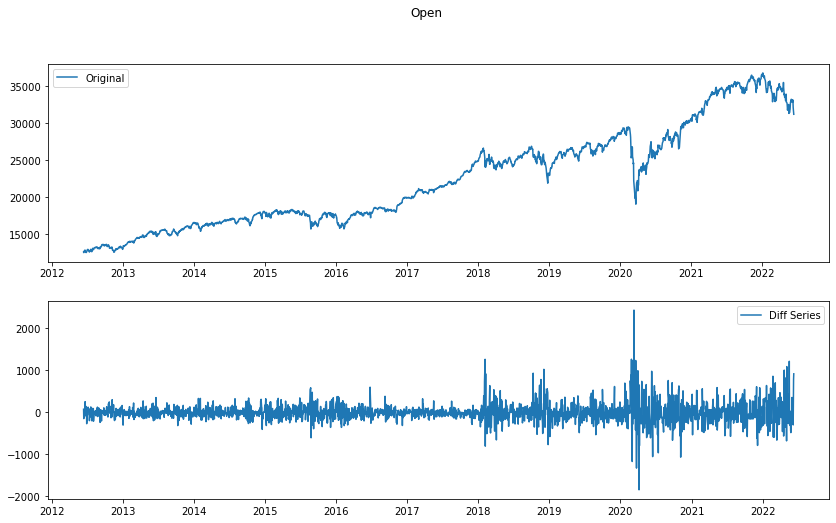

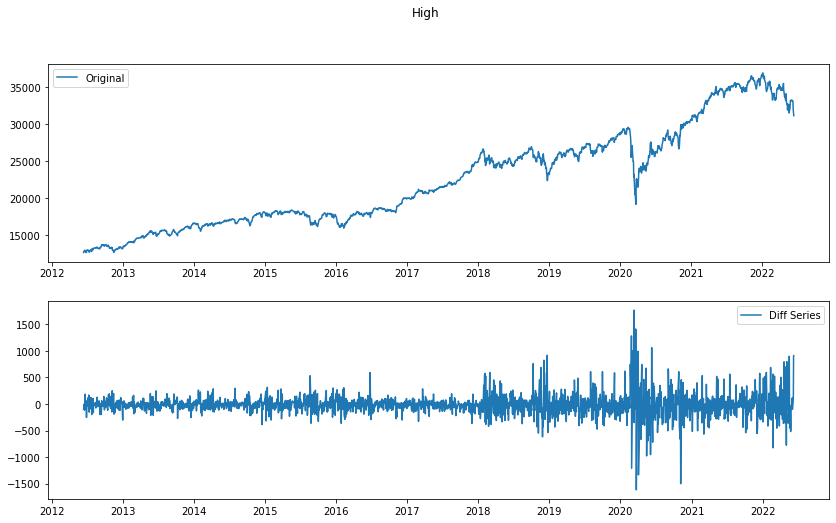

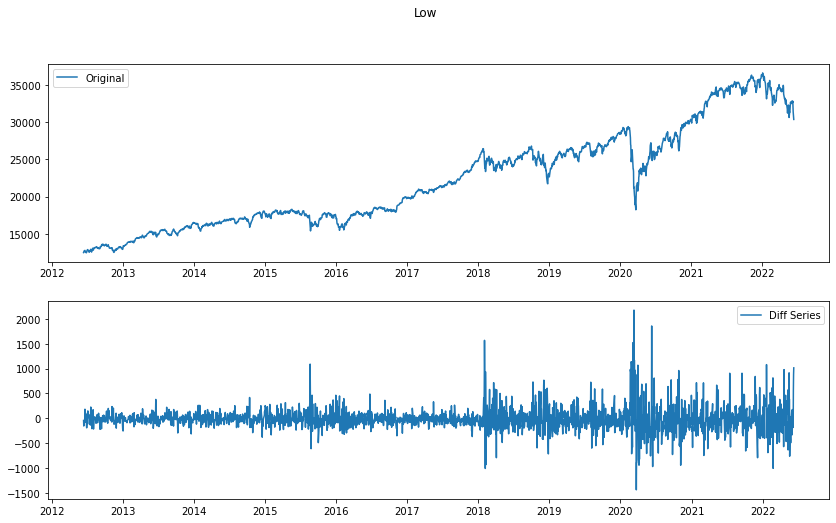

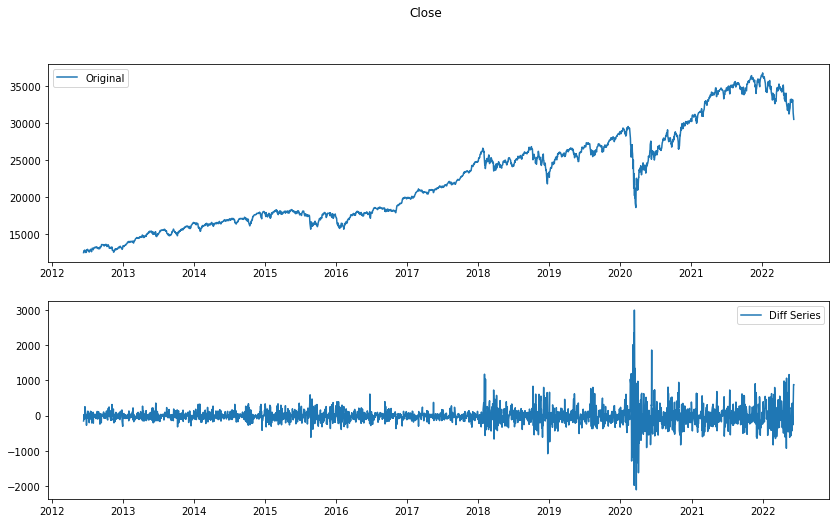

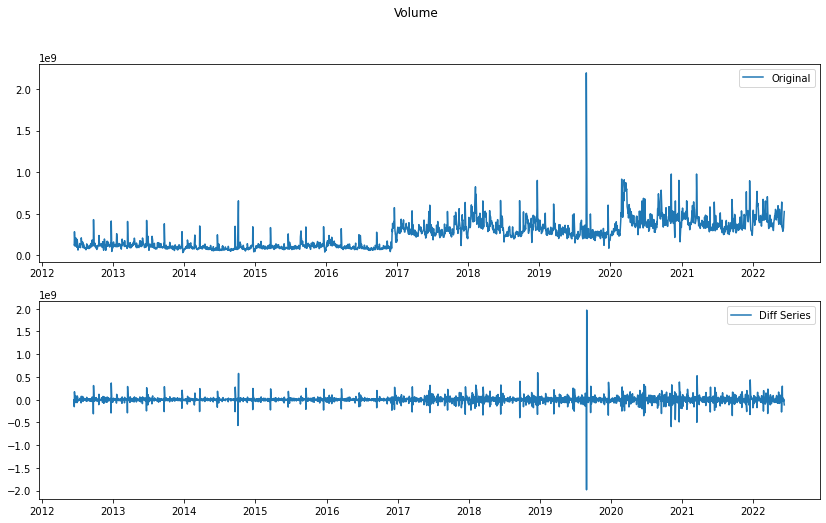

In [156]:
for col in list(dj1.columns):
    plot_diff(dj1[col],col)

In [161]:
def plot_acf_pacf(series,name):
    fig = plt.figure(figsize=(14,8))
    ax1 = fig.add_subplot(211)
    plot_acf(series,lags = 15 ,ax = ax1,title = name+' ACF')
    fig.tight_layout()
    ax2 = fig.add_subplot(212)
    plot_pacf(series,lags = 15,ax = ax2,title = name+' PACF')
    fig.tight_layout()
    plt.show()

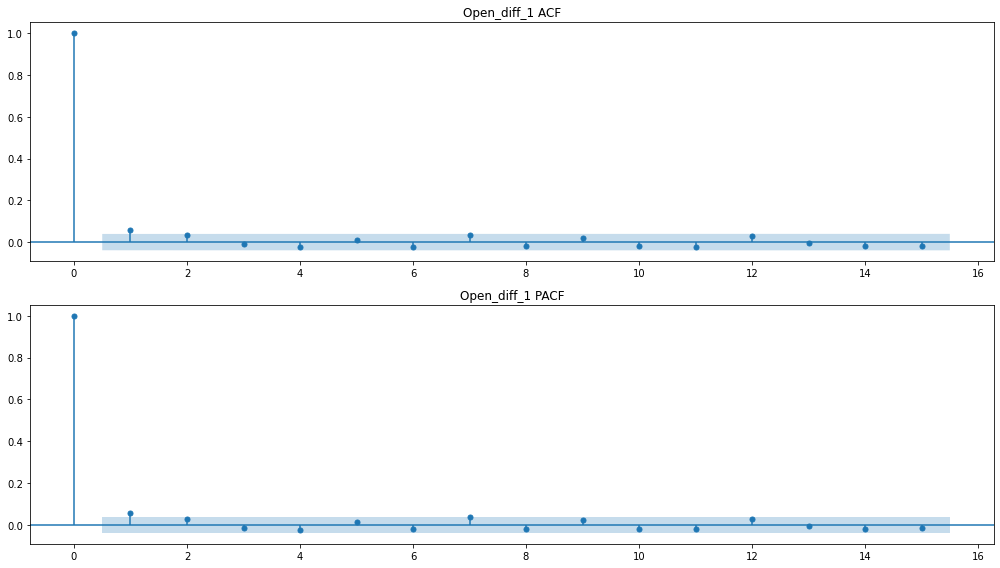

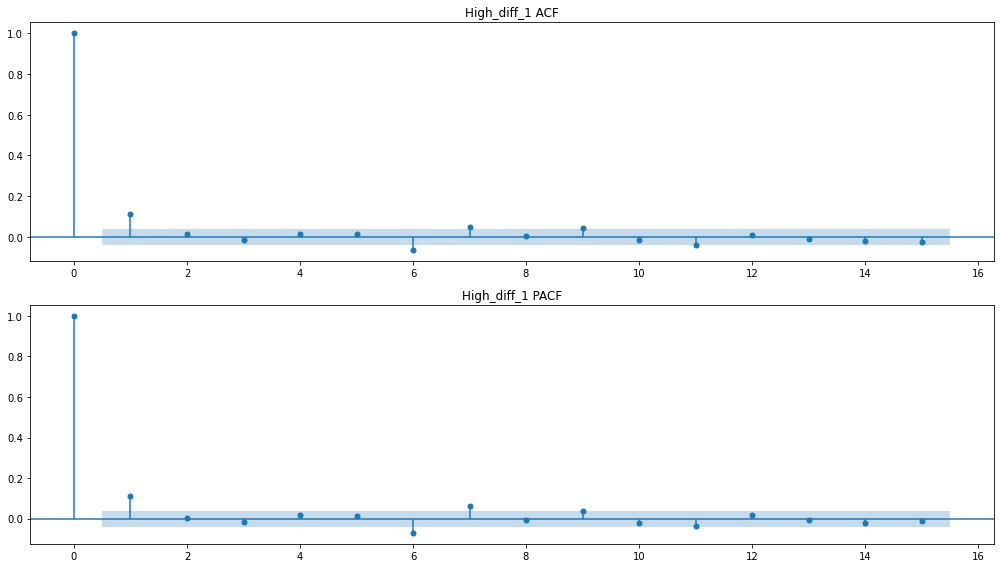

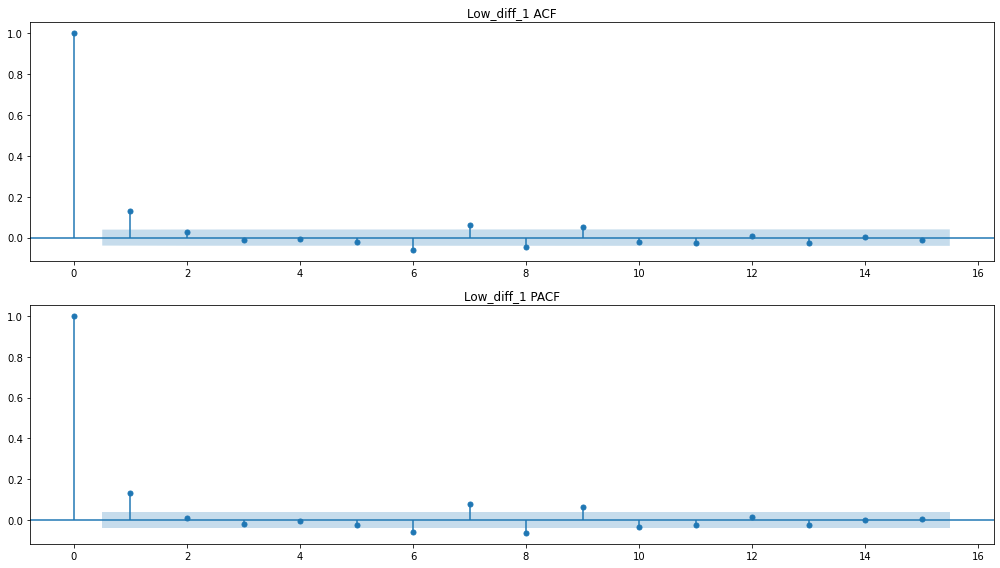

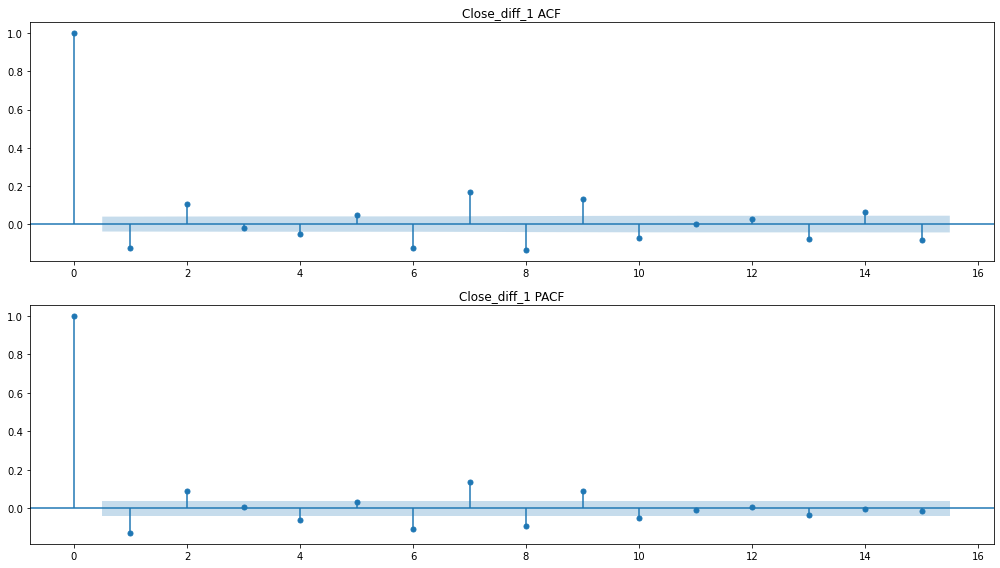

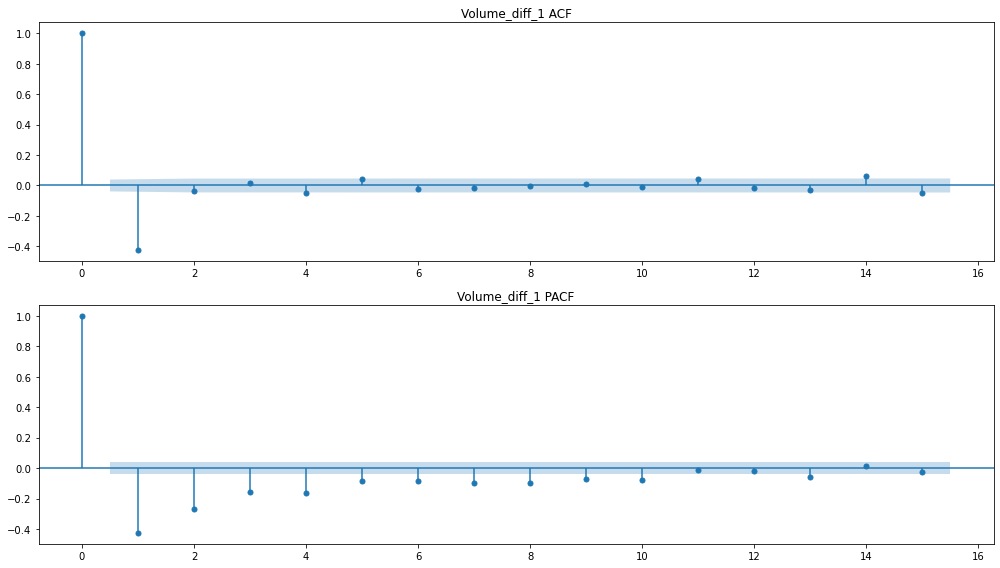

In [162]:
for col in list(dj1.columns):
    plot_acf_pacf(dj1[col].diff(1).dropna(),col+'_diff_1')

In [60]:
res = sm.tsa.arma_order_select_ic(Close_diff_1, ic=["aic", "bic","hqic"], trend="nc")

In [61]:
print(res.aic_min_order,res.bic_min_order,res.hqic_min_order)

(3, 2) (2, 2) (3, 2)


### Either AR(1),AR(2),AR(4),or AR(6),AR(7),AR(8),AR(9)

In [47]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',FutureWarning)

In [167]:
dj1.diff().dropna()

,Open,High,Low,Close,Volume
2022-06-10,908.61,908.61,1014.12,876.05,-114972977.0
2022-06-09,775.10,903.21,879.94,880.00,-80402545.0
2022-06-08,258.45,199.77,556.59,638.11,-17125971.0
2022-06-07,-304.04,50.95,-182.52,269.24,13043224.0
2022-06-06,249.01,27.92,177.65,-264.36,-38169165.0
...,...,...,...,...,...
2012-06-19,-92.48,21.76,-0.45,12.94,6055429.0
2012-06-18,22.40,-117.01,-48.29,-95.51,-13895556.0
2012-06-15,-114.81,-7.23,-44.80,25.35,173163672.0
2012-06-14,-154.32,-76.02,-153.72,-115.26,-155806713.0


In [168]:
def lag_based_IC(data,max_lag):
    ar_orders = range(1,max_lag)
    for col in list(data.columns):
        
        fitted_model_dict = {}
        for idx,ar_order in enumerate(ar_orders):
        #create AR(p) model
            ar_model = ARMA(data[col],order = (ar_order,0))
            ar_model_fit = ar_model.fit()
            fitted_model_dict[ar_order] = ar_model_fit
        AIC = {}
        BIC = {}
        HQIC = {}
        for ar_order in ar_orders:
            AIC[ar_order] = fitted_model_dict[ar_order].aic
            BIC[ar_order] = fitted_model_dict[ar_order].bic
            HQIC[ar_order] = fitted_model_dict[ar_order].hqic
        min_AIC=min(zip(AIC.values(),AIC.keys()))
        min_BIC=min(zip(BIC.values(),BIC.keys()))
        min_HQIC=min(zip(HQIC.values(),HQIC.keys()))
        print("%s :AIC:%f, Min Lag:%s;BIC:%f, Min Lag:%s;HQIC:%f, Min Lag:%s"%(col,min_AIC[0],min_AIC[1],min_BIC[0],min_BIC[1],min_HQIC[0],min_HQIC[1]))

In [170]:
lag_based_IC(dj1.diff().dropna(),15)

Open :AIC:34332.157913, Min Lag:2;BIC:34349.903995, Min Lag:1;HQIC:34338.760820, Min Lag:1
High :AIC:33737.548864, Min Lag:11;BIC:33768.820019, Min Lag:1;HQIC:33757.437642, Min Lag:7
Low :AIC:34387.060836, Min Lag:10;BIC:34435.546095, Min Lag:1;HQIC:34411.286518, Min Lag:9
Close :AIC:34856.707056, Min Lag:10;BIC:34924.384862, Min Lag:9;HQIC:34882.099461, Min Lag:10
Volume :AIC:98693.322721, Min Lag:13;BIC:98767.388613, Min Lag:10;HQIC:98722.815910, Min Lag:10


In [14]:
import mifs

ModuleNotFoundError: No module named 'mifs'